# Opteeq Compter Vision Project - Task B - S3 Read/Write Testing Notebook

In [57]:
# Replace bucket name key and region for testing
in_bucket = 'opteeq-raw-images'
in_key = 'Jonny_1.jpg'
out_bucket = 'opteeq-standardised-images'
out_key = '05cd268e-3973-4333-8c4c-96fdc6af3620.jpg'
region = 'eu-west-1'

This notebook will detail the process of loading and standardizing of recipt images ready to be sent to the GCloud Vision API for labelling. 

The code within this notebook will be tested for functionallity before being put into scripts and packaged as a docker image to be used as an AWS Lambda function. The structure of the notebook is as follows: 

                    1. Things to consider
                    2. Image read and write functions from S3 (boto3)
                    2i. Read and write function testing
                    3. Image standardisation functions using the OpenCV library
                    3i. Image processing function testing

# 2. S3 read/write

We need to load all image files saved in a directory from an AWS S3 bucket. We can perform this task using the low level python sdk boto3.

Images will be read one at a time to deal with AWS Lambda function timeout limits. 

To begin we can use boto3 to access the location of the file in s3 using the bucket name and the file key. Only image extensions compatible with opencv will be accepted ('.JPEG', '.PNG', '.TIFF').  

When writing our information back to S3 we need to save the processed images with a specified file naming convention with a unique id and timestamp. The image will be first saved locally to a temporary directory and then uploaded to the s3 bucket. All images will be saved with the '.jpg' extension. 

In [10]:
import boto3
import botocore 
import cv2
import uuid
import time
import numpy as np
import os
import matplotlib.pyplot as plt

In [65]:
def s3_image_read(bucket_name: str, key: str) -> 'numpy.ndarray':
    """
    Read a single image from AWS S3 bucket into a numpy array using OpenCV
    :param bucket_name: Bucket name
    :param key: Key to S3 bucket directory
    :return: Image array
    """
    # Create s3 resource and s3 bucket object using boto3
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucket_name)

    # Try and load an image using boto3 and OpenCV,
    # Print exception if extension is not OpenCV compatible or there is a boto3 error
    try:
        if key.endswith(".jpg") or key.endswith(".jpeg") or key.endswith(".png") or key.endswith(".tiff"):
            content = bucket.Object(key).get().get('Body').read()
            img = cv2.imdecode(np.asarray(bytearray(content)), cv2.IMREAD_COLOR)
            return img
        else:
            return 'Invalid file extension. Must be .jpg, .jpeg, .png or .tiff'
    except botocore.exceptions.ClientError as e:
        return e.response

def s3_image_write(bucket_name: str, key: str, processed_img: 'numpy.ndarray') -> 'Str':
    """
    Write a single image to a local file then push to an S3 bucket in .jpg format
    :param bucket_name: Bucket name
    :param key: Key to S3 bucket directory
    :param processed_img: Standardised image array
    :param unique_id: Unique randomly generated uuid
    :param timestamp: Unix timestamp
    :return: None
    """
    # Create s3 resource and s3 bucket object using boto3
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucket_name)

    # Generate unique id and timestamp for filename
    # In practice timestamp will be used from s3 event
    timestamp = str(int(time.time()))
    unique_id = str(uuid.uuid4())

    # Write image to local directory using OpenCV
    if not os.path.exists('tmp'):
        os.mkdir('tmp')

    filename = '{}.jpg'.format(unique_id)
    
    local_path = os.path.join('tmp', filename)

    cv2.imwrite(local_path, processed_img)

    # Try to upload local file to S3 bucket, return error message if upload fails
    try:
        bucket.upload_file(local_path, filename)
        return "Image upload success"
    except botocore.exceptions.ClientError as e:
        return e.response

def db_write(in_key: str, out_key: str, timestamp: str = int(time.time()), table_name: str = "opteeq-dataset-table",  region: str = 'eu-west-1') -> str: 
    """
    Write an image to AWS DynamoDB 
    :param table_name: DynamoDB Table name
    :param processed_img: Standardised image array
    :param region: AWS region name where database is located
    :return: None
    """
    # Extract name of uploader and increment information from file name 
    uploader_name, increment = in_key.split('_')[:2]
    
    # Creation of client for dynamodb
    table = boto3.resource('dynamodb', region_name=region).Table(table_name)
    
    content = {
                "standKey": out_key,
                "rawKey": in_key,
                "uploaderName": uploader_name,
                "uploadTime": timestamp,
                "initAnotKey": '',
                "finalAnotKey": '',
                "anotName": '',
                "finalAnotTime": 0
                }
    try: 
        response = table.put_item(Item=content)
        return response
    except botocore.exceptions.ClientError as e:
        return e.response

# 2a. S3 read/write function testing

# (i) S3 image read function testing

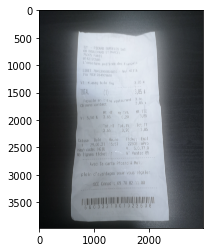

In [45]:
img = s3_image_read(in_bucket, in_key)

plt.imshow(img)

# (ii) S3 image write function testing

In [46]:
s3_image_write(out_bucket, out_key, img)

'Image upload success'

# (iii) DynamoDB table update

In [66]:
db_write(in_key, out_key)

{'ResponseMetadata': {'RequestId': 'PLB42NEVGDFV1NJDLCHRS11NU3VV4KQNSO5AEMVJF66Q9ASUAAJG',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Fri, 06 Aug 2021 14:30:26 GMT',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'PLB42NEVGDFV1NJDLCHRS11NU3VV4KQNSO5AEMVJF66Q9ASUAAJG',
   'x-amz-crc32': '2745614147'},
  'RetryAttempts': 0}}